Рванова Людмила, М05-016а

In [2]:
!pip install matplotlib python-sat

     |████████████████████████████████| 1.8 MB 997 kB/s eta 0:00:01
You should consider upgrading via the '/home/mila/anaconda3/envs/my-env/bin/python -m pip install --upgrade pip' command.


In [194]:
import re
from pysat.solvers import Solver #используемый солвер
s = Solver(name='mc')
from matplotlib import patches
from matplotlib import pyplot as plt
from itertools import chain

In [85]:
def get_numbers(xy):
    x, y = map(int, xy.split(','))
    
    return x, y

def reading(file):
    points = []
    uid = 1
    for line in file.split('\n'):
        start, size, positions = line.split('\t')
        
        xs, ys = get_numbers(start)
        curr_point = {(xs, ys): []}
        w, h = get_numbers(size)
        
        for position in positions.split(' '):
            x_pos, y_pos = get_numbers(position)
            
            rect_xs = xs - x_pos
            rect_ys = ys - y_pos
            
            if rect_xs < 0:
                continue
            elif rect_ys < 0:
                continue
            elif rect_xs + w > 500:
                continue
            elif rect_ys + h > 500:
                continue
                
            curr_rect = (rect_xs, rect_ys, w, h, uid)
            curr_point[(xs, ys)].append(curr_rect)
            
            uid += 1
        points.append(curr_point)
    return points

def contains(rect, x, y):
    rect_xs, rect_ys, w, h, uid = rect
    
    if rect_xs <= x and rect_ys <= y:
        if rect_xs + w >= x and rect_ys + h >= y:
            return True
        
    return False

# Check intersection of two rectangles
def intersects(lhs, rhs):
    lhs_rect_xs, lhs_rect_ys, lhs_w, lhs_h, lhs_uid = lhs
    
    for x, y in [(lhs_rect_xs, lhs_rect_ys),
                 (lhs_rect_xs + lhs_w, lhs_rect_ys),
                 (lhs_rect_xs, lhs_rect_ys + lhs_h),
                 (lhs_rect_xs + lhs_w, lhs_rect_ys + lhs_h)]:
        if contains(rhs, x, y):
            return True
        
    return False    

def find_collisions(rects):
    collisions = {}

    for lhs in rects:
        for rhs in rects:
            lhs_rect_xs, lhs_rect_ys, lhs_w, lhs_h, lhs_uid = lhs
            rhs_rect_xs, rhs_rect_ys, rhs_w, rhs_h, rhs_uid = rhs
            
            if lhs_uid != rhs_uid and intersects(lhs, rhs):
                if lhs_uid not in collisions:
                    collisions[lhs_uid] = set()
                collisions[lhs_uid].add(rhs_uid)

    return collisions

In [86]:
def solve(points):
    frames = []
    for curr_point in points:
        frames.append(curr_point.values()) 
    for i in range(2):
        frames = list(chain.from_iterable(frames))
    frames_d = {}
    for curr_rect in frames:
        frames_d[curr_rect[4]] = curr_rect
    collisions = find_collisions(frames)
    
    for curr_point in points:
        r_uid = []
        iterator = iter(curr_point.values())
        for curr_rect in next(iterator):
            r_uid.append(curr_rect[4])
        s.add_clause(r_uid)
        s.add_atmost(r_uid, 1) #ограничение для солвера
    for curr_rect in frames:
        if curr_rect[4] in collisions:
            for case in collisions[curr_rect[4]]:
                s.add_clause([-curr_rect[4], -case])
    frame_ids = s.get_model()
    try:
        frame_ids.get_model()
        result = []
        for frame_id in frame_ids:
            if frame_id > 0:
                result.append(frames_d[frame_id])
        return(result)
    except:
        print('No solution')
    s.delete()
    

In [205]:
def solve(points):
    frames = []
    for curr_point in points:
        frames.append(curr_point.values()) 
    for i in range(2):
        frames = list(chain.from_iterable(frames))
    
    
    
    with Solver(name="mc") as s:
        frames_d = {}
        for curr_rect in frames:
            frames_d[curr_rect[4]] = curr_rect
            collisions = find_collisions(frames)
#         print(frames_d)
#         print(frames_d[1])
    
        for curr_point in points:
            r_uid = []
            iterator = iter(curr_point.values())
            for curr_rect in next(iterator):
                r_uid.append(curr_rect[4])
            s.add_clause(r_uid)
            s.add_atmost(r_uid, 1) #ограничение для солвера
            
        for curr_rect in frames:
            if curr_rect[4] in collisions:
                for case in collisions[curr_rect[4]]:
                    s.add_clause([-curr_rect[4], -case])
#         try:
#             frame_ids= s.get_model()
#             result = []
#             for frame_id in frame_ids:
#                 if frame_id > 0:
#                     result.append(frames_d[frame_id])
#             return(result)
#         except:
#                 print('No solution')
#                 raise
        if s.solve():
            result = []
            frame_ids = s.get_model()
            for frame_id in frame_ids:
                if frame_id > 0:
#                     print(frames_d)
                    result.append(frames_d[frame_id])
            return(result)
        else:
            print('No solution.')
            raise


In [207]:
def do_the_plot(file):
    points = reading(file)
    labels = solve(points)
    fig, ax = plt.subplots()
    points_list = []
    for curr_point in points:
        iterator = iter(curr_point.keys())
        item = next(iterator)
        points_list.append(item)
    
    x = []
    y = []
    rectangles = []
    for point in points_list:
        x.append(point[0])
        y.append(point[1])
        
    ax.scatter(x, y, color='red')
    for i, curr_rect in enumerate(labels):
        rectangles.append(patches.Rectangle(xy=(curr_rect[0], curr_rect[1]), width=curr_rect[2], height=curr_rect[3]))
    
    for rectangle in rectangles:
        ax.add_patch(rectangle)
    plt.show()    

In [208]:
hard1 = """111,152	33,47	0,0 33,0 0,47 33,47
55,142	35,25	0,0 35,0 0,25 35,25
73,62	40,21	0,0 40,0 0,7 40,7 0,14 40,14 0,21 40,21
54,193	10,48	0,0 10,0 0,48 10,48
191,7	18,47	0,0 6,0 12,0 18,0 0,47 6,47 12,47 18,47
187,135	29,23	0,0 29,0 0,23 29,23
174,50	45,22	0,0 15,0 30,0 45,0 0,22 15,22 30,22 45,22
33,31	34,29	0,0 34,0 0,29 34,29
193,174	14,14	0,0 14,0 0,14 14,14
155,140	25,20	0,0 25,0 0,20 25,20
136,92	20,31	0,0 20,0 0,31 20,31
71,187	25,29	0,0 25,0 0,29 25,29
104,38	53,11	0,0 53,0 0,11 53,11
83,41	14,24	0,0 14,0 0,24 14,24
29,158	16,41	0,0 16,0 0,41 16,41
7,107	31,21	0,0 31,0 0,21 31,21
128,5	15,10	0,0 15,0 0,10 15,10
53,111	12,20	0,0 12,0 0,20 12,20
22,5	24,10	0,0 12,0 24,0 0,10 12,10 24,10
167,5	11,42	0,0 11,0 0,42 11,42
114,125	10,23	0,0 10,0 0,23 10,23
143,145	11,45	0,0 11,0 0,45 11,45
57,100	37,18	0,0 37,0 0,18 37,18
176,99	12,32	0,0 12,0 0,32 12,32
28,130	18,12	0,0 18,0 0,12 18,12"""

In [209]:
bin1 = '''33,45	38,24	19,0 38,0
148,94	55,47	0,0 55,0
198,30	50,21	0,21 50,0
75,62	54,31	0,0 0,31
41,19	11,24	0,0 11,0
71,143	29,21	29,0 29,21
149,187	54,33	0,0 54,33
78,161	44,38	22,0 44,0
56,117	30,25	0,25 30,0
188,75	35,30	35,10 35,30
11,182	10,18	0,0 10,18
198,174	17,16	0,16 17,16
53,91	22,10	0,0 22,10
167,125	34,22	17,11 34,22
174,5	41,12	41,0 41,12
185,180	15,24	0,8 15,0
127,91	26,24	0,0 26,24
11,116	12,21	0,21 4,0
26,147	13,12	0,12 13,12
90,122	15,20	0,20 15,0
55,75	15,19	0,19 15,0
94,173	15,26	15,0 15,26
167,140	16,22	0,0 16,0
94,13	14,14	0,0 14,14'''

In [210]:
hard2 = '''134,105	33,19	0,0 33,0 0,19 33,19
171,60	13,42	0,0 13,0 0,42 13,42
118,70	55,44	0,0 55,0 0,44 55,44
26,113	32,42	0,0 32,0 0,21 32,21 0,42 32,42
161,44	20,12	0,0 10,0 20,0 0,4 10,4 20,4 0,8 10,8 20,8 0,12 10,12 20,12
42,49	16,39	0,0 16,0 0,13 16,13 0,26 16,26 0,39 16,39
81,184	51,23	0,0 51,0 0,23 51,23
180,168	46,11	0,0 23,0 46,0 0,11 23,11 46,11
164,199	17,18	0,0 17,0 0,18 17,18
163,39	27,29	0,0 27,0 0,29 27,29
58,11	29,28	0,0 29,0 0,28 29,28
106,190	36,49	0,0 36,0 0,49 36,49
197,118	18,28	0,0 18,0 0,28 18,28
92,115	20,27	0,0 20,0 0,27 20,27
134,100	14,10	0,0 14,0 0,10 14,10
54,186	38,12	0,0 38,0 0,12 38,12
201,41	10,46	0,0 10,0 0,23 10,23 0,46 10,46
12,92	22,23	0,0 22,0 0,23 22,23
88,155	12,27	0,0 4,0 8,0 12,0 0,27 4,27 8,27 12,27
175,158	27,25	0,0 27,0 0,25 27,25
199,133	20,32	0,0 20,0 0,32 20,32
91,186	23,13	0,0 23,0 0,13 23,13
135,75	21,28	0,0 21,0 0,28 21,28'''

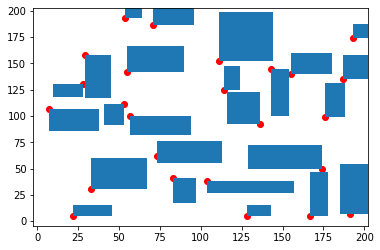

In [211]:
do_the_plot(hard1)

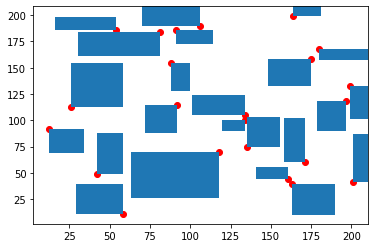

In [213]:
do_the_plot(hard2)

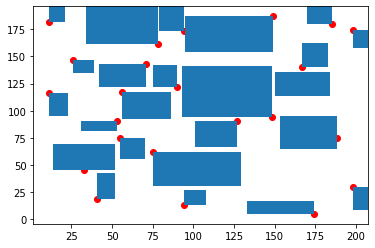

In [214]:
do_the_plot(bin1)